# Decision Tree Approach

## Setup

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.calibration import calibration_curve

pd.set_option('display.max_rows', 500)

k2_df = pd.read_csv('data/K2_2024.06.06_20.23.11.csv', comment='#')
kep_df = pd.read_csv('data/KOI_2024.06.06_20.22.41.csv', comment='#')

## Exploring Columns, Shape, and Distribution

In [12]:
print(k2_df.shape)
print(k2_df['disposition'].value_counts())

(3839, 16)
disposition
CONFIRMED         2156
CANDIDATE         1372
FALSE POSITIVE     293
REFUTED             18
Name: count, dtype: int64


In [13]:
k2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pl_name      3839 non-null   object 
 1   hostname     3839 non-null   object 
 2   disposition  3839 non-null   object 
 3   pl_orbper    3800 non-null   float64
 4   pl_orbsmax   777 non-null    float64
 5   pl_rade      3030 non-null   float64
 6   pl_insol     519 non-null    float64
 7   pl_eqt       709 non-null    float64
 8   pl_trandur   2718 non-null   float64
 9   st_teff      2731 non-null   float64
 10  st_rad       3715 non-null   float64
 11  st_mass      1968 non-null   float64
 12  st_met       1568 non-null   float64
 13  st_logg      2204 non-null   float64
 14  sy_dist      3716 non-null   float64
 15  sy_kepmag    3824 non-null   float64
dtypes: float64(13), object(3)
memory usage: 480.0+ KB


In [14]:
print(kep_df.shape)
print(kep_df['koi_disposition'].value_counts())

(9564, 16)
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2743
CANDIDATE         1982
Name: count, dtype: int64


In [15]:
kep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepid            9564 non-null   int64  
 1   kepoi_name       9564 non-null   object 
 2   kepler_name      2745 non-null   object 
 3   koi_disposition  9564 non-null   object 
 4   koi_period       9564 non-null   float64
 5   koi_duration     9564 non-null   float64
 6   koi_prad         9201 non-null   float64
 7   koi_sma          9201 non-null   float64
 8   koi_teq          9201 non-null   float64
 9   koi_insol        9243 non-null   float64
 10  koi_steff        9201 non-null   float64
 11  koi_slogg        9201 non-null   float64
 12  koi_smet         9178 non-null   float64
 13  koi_srad         9201 non-null   float64
 14  koi_smass        9201 non-null   float64
 15  koi_kepmag       9563 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 1.2+ MB


## Data Prep
### Data Augmentation
Since the initial dataset only had a few hundred negative cases vs a few thousand positive ones, we decided to augment our data with observations from another telescope. Many of the readings were the same so we were able to create a mapping to get a single DF with records from both.

In [16]:
column_mapping = {
    'status': ['disposition', 'koi_disposition'], # target, status of the object
    'orbital_period': ['pl_orbper', 'koi_period'], # orbital period
    'semi_major_axis': ['pl_orbsmax', 'koi_sma'], # semi-major axis
    'planet_radius': ['pl_rade', 'koi_prad'], # planet radius
    'transit_duration': ['pl_trandur', 'koi_duration'], # transit duration
    'insolation_flux': ['pl_insol', 'koi_insol'], # insolation flux
    'equilibrium_temperature': ['pl_eqt', 'koi_teq'], # equilibrium temperature
    'kepler_magnitude': ['sy_kepmag', 'koi_kepmag'], # Kepler magnitude
    'stellar_radius': ['st_rad', 'koi_srad'], # stellar radius
    'stellar_effective_temperature': ['st_teff', 'koi_steff'], # stellar effective temperature
    'stellar_surface_gravity': ['st_logg', 'koi_slogg'], # stellar surface gravity
    'stellar_mass': ['st_mass', 'koi_smass'], # stellar mass
    'stellar_metallicity': ['st_met', 'koi_smet'] # stellar metallicity
}

In [17]:
# Create mappings for K2 and Kepler datasets
k2_column_mapping = {v[0]: k for k, v in column_mapping.items()}
kep_column_mapping = {v[1]: k for k, v in column_mapping.items()}

k2_df_selected = k2_df[k2_column_mapping.keys()].rename(columns=k2_column_mapping)
kep_df_selected = kep_df[kep_column_mapping.keys()].rename(columns=kep_column_mapping)

combined_df = pd.concat([k2_df_selected, kep_df_selected], axis=0, ignore_index=True)

print("combined_df shape:", combined_df.shape)

combined_df shape: (13403, 13)


In [18]:
disposition_counts = combined_df['status'].value_counts()
print("Distribution:")
print(disposition_counts)

Distribution:
status
FALSE POSITIVE    5132
CONFIRMED         4899
CANDIDATE         3354
REFUTED             18
Name: count, dtype: int64


In [19]:
df = combined_df[combined_df['status'] != 'CANDIDATE']
df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})

disposition_counts = df['status'].value_counts()
print("Distribution:")
print(disposition_counts)

Distribution:
status
0    5150
1    4899
Name: count, dtype: int64


C:\Users\kflin\AppData\Local\Temp\ipykernel_24924\1669363882.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})
C:\Users\kflin\AppData\Local\Temp\ipykernel_24924\1669363882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})


### Remove Nulls

In [20]:
# count null values
null_counts = df.isnull().sum()
print("Null Counts:")
print(null_counts)

Null Counts:
status                              0
orbital_period                     19
semi_major_axis                  1981
planet_radius                     800
transit_duration                  916
insolation_flux                  2219
equilibrium_temperature          2100
kepler_magnitude                    8
stellar_radius                    353
stellar_effective_temperature     784
stellar_surface_gravity          1131
stellar_mass                     1128
stellar_metallicity              1517
dtype: int64


In [21]:
# drop rows with null values
df = df.dropna()

disposition_counts = df['status'].value_counts()
print("Distribution:")
print(disposition_counts)

Distribution:
status
0    4561
1    2825
Name: count, dtype: int64


### Define Features and Target

In [22]:
X = df.drop(columns=['status'])
y = df['status']

### Normalize Features and Fix Class Imbalance
Though normalization is not necessary for decision trees, I did it anyways so that all of our different models could be evaluated using the same prepared data.  

I also tried correcting the class imbalance, but fixing it did not improve model performance. It seemed that the imbalance was not great enough to cause problems for the model's learning.

In [23]:
scalar = StandardScaler()
X = scalar.fit_transform(X)

### Under Sampling and Over Sampling were tested but did not improve the model

#rus = RandomUnderSampler(random_state=0)
#X, y = rus.fit_resample(X, y)

#ros = RandomOverSampler(random_state=0)
#X, y = ros.fit_resample(X, y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (7386, 12)
y shape: (7386,)


### Train / Test / Validation Splits

In [24]:
# 70/15/15 train/test/val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print("X:", X.shape, "X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_val shape:", X_val.shape)

X: (7386, 12) X_train shape: (5170, 12) X_test shape: (1108, 12) X_val shape: (1108, 12)


## Models
### Hyperparameter Tuning
Finding the best parameters for the model. Compute constraints forced me to do a more minimal search for the boosting model.

In [25]:
# Commenting out to avoid running grid search again

#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

#rf_model = RandomForestClassifier(random_state=0)
#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
#grid_search.fit(X_train, y_train)

#best_rf_model = grid_search.best_estimator_
#print("Best parameters for RF Model:", grid_search.best_params_)

In [26]:
# Commenting out to avoid running grid search again

#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#}

#gb_model = GradientBoostingClassifier(random_state=0)
#grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
#grid_search.fit(X_train, y_train)

#best_gb_model = grid_search.best_estimator_
#print("Best parameters for GB Model:", grid_search.best_params_)

### Bootstrap Aggregation

In [27]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, max_depth= None, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

### Gradient Boosting

In [28]:
gb_model = GradientBoostingClassifier(n_estimators=300, max_depth= 10, random_state=0)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=300, random_state=0)

## Evaluation

### Basics Performance Metrics  

Because the goal of our project is not necessarily just accurate binary classification, it was important to examine log loss as well as the model's accuracy and confusion matrix.

In [29]:
rf_y_pred_prob = rf_model.predict_proba(X_val)
rf_y_pred = rf_model.predict(X_val)

rf_log_loss = log_loss(y_val, rf_y_pred_prob)
rf_accuracy = accuracy_score(y_val, rf_y_pred)
rf_confusion_matrix = confusion_matrix(y_val, rf_y_pred)

In [30]:
gb_y_pred_prob = gb_model.predict_proba(X_val)
gb_y_pred = gb_model.predict(X_val)

gb_log_loss = log_loss(y_val, gb_y_pred_prob)
rf_accuracy = accuracy_score(y_val, gb_y_pred)
gb_confusion_matrix = confusion_matrix(y_val, gb_y_pred)

In [31]:
print("Random Forest Log Loss:", rf_log_loss)
print("Random Forest Accuracy:", rf_accuracy)

print("Gradient Boosting Log Loss:", gb_log_loss)
print("Gradient Boosting Accuracy:", rf_accuracy)

Random Forest Log Loss: 0.2830521677272963
Random Forest Accuracy: 0.9115523465703971
Gradient Boosting Log Loss: 0.4187717031042331
Gradient Boosting Accuracy: 0.9115523465703971


### Confusion Matrix

In [32]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)

    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
        
    plt.tight_layout()
    plt.show()

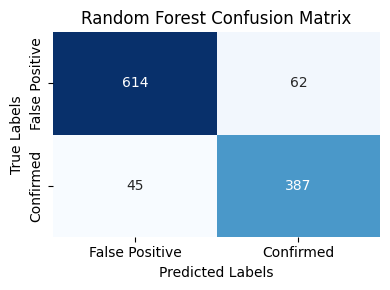

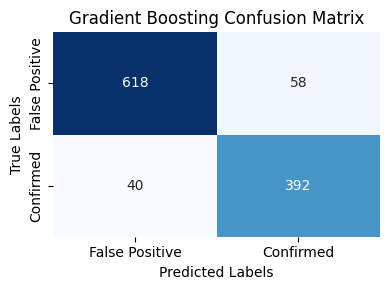

In [33]:
plot_confusion_matrix(rf_confusion_matrix, ['False Positive', 'Confirmed'], title='Random Forest Confusion Matrix')
plot_confusion_matrix(gb_confusion_matrix, ['False Positive', 'Confirmed'], title='Gradient Boosting Confusion Matrix')

### Cross-Validation
Performing cross-validation to ensure that the results seen in a single model aren't a fluke.

In [34]:
k = 5

kf = KFold(n_splits=k, random_state=0, shuffle=True)

rf_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')

print("Random Forest Cross Validation Accuracy Mean:", rf_scores.mean())

gb_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='accuracy')

print("Gradient Boosting Cross Validation Accuracy Mean:", gb_scores.mean())

Random Forest Cross Validation Accuracy Mean: 0.9044135471913499
Gradient Boosting Cross Validation Accuracy Mean: 0.9110482518142415


### Calibration Curve
The objective of the project is to provide accurate probabilities to help astronomers determine which planets are most likely to be exoplanets and so where to focus their time and resources for best results. A calibration curve can help show not just how accurate the model's classifications were, but how well the probabilities that it predicted align with the actual number of positive classifications. A model calibration curve that aligns well with the ideal calibration curve shows that the predicted probabilities are likely on track. In other words, if the model says that there are 10 planets with a 70% chance of being an exoplanet then 7 out of 10 of those will in fact be exoplanets.

In [35]:
def plot_calibration_curve(y_true, y_prob, title):
    plt.figure(figsize=(8, 6))
    plt.plot(y_prob, y_true, 's-', label='Calibration curve')
    plt.plot([0, 1], [0, 1], color='gray', label='Ideal calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend()
    plt.show()

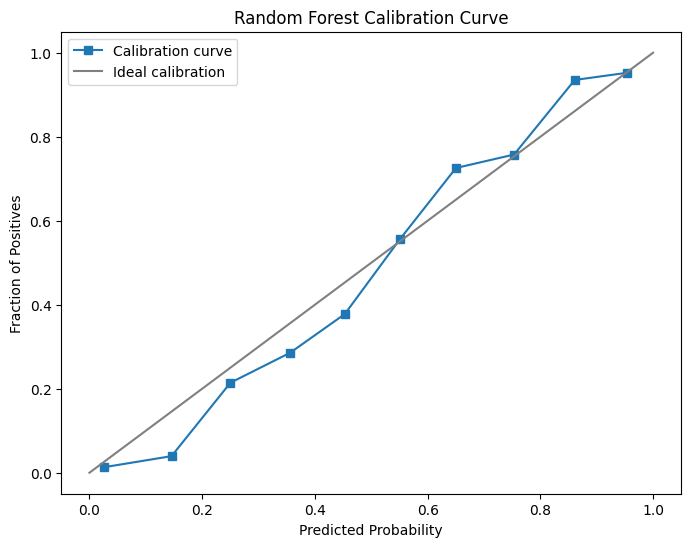

In [36]:
prob_true, prob_pred = calibration_curve(y_val, rf_y_pred_prob[:, 1], n_bins=10)

plot_calibration_curve(prob_true, prob_pred, title='Random Forest Calibration Curve')

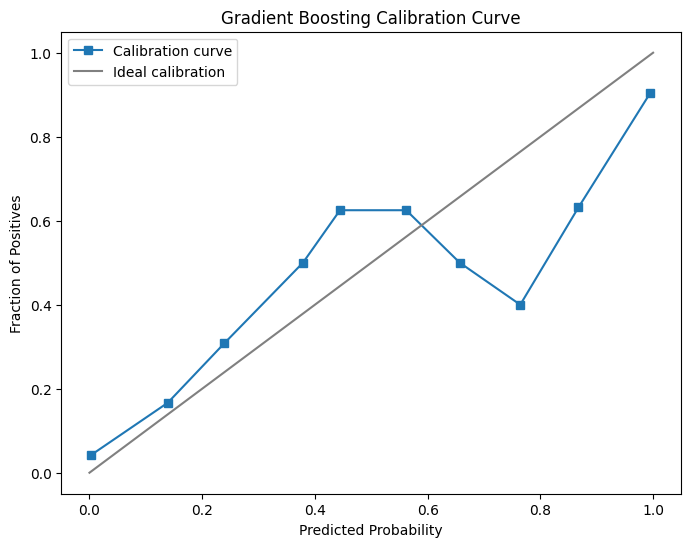

In [37]:
prob_true, prob_pred = calibration_curve(y_val, gb_y_pred_prob[:, 1], n_bins=10)

plot_calibration_curve(prob_true, prob_pred, title='Gradient Boosting Calibration Curve')

### Decision Tree Model Conclusion

While the gradient boosted model tends to be slightly more accurate, it also shows poor alignment with the ideal calibration curve for predictions in the range of roughly 40% to 90%. The random forest has slightly lower binary accuracy, but is generally very precise in it's estimation of probabilities. For our scenario, I believe that the the random forest model is preferable.